### PLS regression from untrained Alexnet layer outputs to voxel responses

In [1]:
#basic imports
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats
import os

from sklearn.cross_decomposition import PLSRegression

In [2]:
import regression_utils as rutils
from sklearn.model_selection import GridSearchCV

#local imports
from utils import featurewise_norm
from utils import rsquared

In [3]:
# let's bring in the brain data

#read in the mat files
with h5py.File('../data/EstimatedResponses.mat','r') as fmri_dataset:
    train_S1 = fmri_dataset['dataTrnS1'][:]
    test_S1 = fmri_dataset['dataValS1'][:]
    roi_S1 = fmri_dataset['roiS1'][:]
    
    unique_ROIs = np.unique((fmri_dataset['roiS1']))

In [4]:
#get rid of all NaNs
S1 = train_S1.T
x=S1[~np.isnan(S1).any(axis=1)]
S1_train = x.T
print(S1_train.shape)

num_vox = S1_train.shape[1]

S1r = roi_S1.T
x=S1r[~np.isnan(S1).any(axis=1)]
vox_idx = x.T
vox_idx = vox_idx[0]
print(len(vox_idx))

(1750, 22733)
22733


In [5]:
#number of voxels that were classified as one of the visual ROIs of interest (V1, V2, V3, V4, LO)
num_vox_of_roi = (len(np.where(vox_idx==7)[0])
                  + len(np.where(vox_idx==6)[0])
                  + len(np.where(vox_idx==1)[0])
                  +len(np.where(vox_idx==2)[0])
                  +len(np.where(vox_idx==3)[0]))

In [6]:
#all splits for regression training
num_splits = 5
all_splits = rutils.get_splits(data=S1_train,
                               split_index=0,
                               num_splits=num_splits,
                               num_per_class_test = 250,
                               num_per_class_train = 1500)

In [7]:
# read in the alexnet features
features = {}
layer_keys = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']
h5f = h5py.File('../models/features/alexnet/alexnet_untrained_train_features.h5','r')
for l in layer_keys:
    features[l] = h5f[l][:] #features for the training images
h5f.close()

In [8]:
#flatten the features
flat_features = {}
for l in layer_keys:
    shp = features[l].shape
    flat_features[l] = features[l].reshape((shp[0], np.prod(shp[1:])))
    
#and subsample the features
sub_features = {}
N = 1250
#create a random number generator with controlled seed
rng = np.random.RandomState(seed=0)
for l in layer_keys:
    #n = number of features
    n = flat_features[l].shape[1]  
    #pick a permutation of the set [0, ... n-1]
    perm = rng.permutation(n)
    #keep the first N random features
    keep_inds = perm[: N]
    sub_features[l] = flat_features[l][:, keep_inds]

In [9]:
#now, do the training
all_resdict = {}
for l in layer_keys:   #for each layer ...
    print('evaluating %s' % l)
    feats = sub_features[l]

    res = rutils.train_and_test_scikit_regressor(features=feats, 
                                                labels=S1_train,
                                                splits=all_splits,
                                                model_class=PLSRegression,
                                                model_args={'n_components': 2,
                                                            'scale': False},
                                                feature_norm=False)
    all_resdict[l] = res

evaluating conv1
evaluating conv2
evaluating conv3
evaluating conv4
evaluating conv5
evaluating fc6
evaluating fc7


In [10]:
#divide performance explicitly by layer
conv1 = all_resdict['conv1']['test']['mean_rsquared_array']
conv2 = all_resdict['conv2']['test']['mean_rsquared_array']
conv3 = all_resdict['conv3']['test']['mean_rsquared_array']
conv4 = all_resdict['conv4']['test']['mean_rsquared_array']
conv5 = all_resdict['conv5']['test']['mean_rsquared_array']
fc6 = all_resdict['fc6']['test']['mean_rsquared_array']
fc7 = all_resdict['fc7']['test']['mean_rsquared_array']

In [11]:
#get the best performing layer for each voxel
best_layer_by_vox = {}
for vox in range(num_vox):
    rs_by_layer = [conv1[vox], conv2[vox], conv3[vox], conv4[vox], conv5[vox], fc6[vox], fc7[vox]]
    best_layer_by_vox[vox] = np.argmax(rs_by_layer)

In [12]:
#get all significantly predicted voxels (p < .05, one-sided)
stat_vox = []
stat_rs = {}
r_mean = []
stat_rs_mean = {}
for vox in range(num_vox):
    rs_by_split = []
    for split in range(num_splits): #get output for winning layer for all splits
        layer_win = best_layer_by_vox[vox]
        win_key = layer_keys[layer_win]
        rs_by_split.append(all_resdict[win_key]['test']['by_split'][split]['rsquared_array'][vox])
    
    r_mean.append(all_resdict[win_key]['test']['mean_rsquared_array'][vox]) #all mean r^2 across splits 
    
    t, p = stats.ttest_1samp(rs_by_split, 0.0)
    p = p/2 #one-sided
    if t > 0: #only positive fits
        if p < .05:
            stat_vox.append(vox) #indices of stat sig voxels
            stat_rs[str(vox)] = rs_by_split
            stat_rs_mean[str(vox)] = all_resdict[win_key]['test']['mean_rsquared_array'][vox]

In [ ]:
## okay, how's the untrained model?

In [13]:
## get some general metrics of performance
#proportion of sig. predicted voxels within ROIs of interest by this threshold
prop_sig = len(stat_vox)/num_vox_of_roi
#validation r^2 value for best predicted voxel
best_vox = max(stat_rs_mean.values())
best_vox_idx = max(stat_rs_mean, key=stat_rs_mean.get)

print("Percentage of significantly predicted voxels: %s" % (prop_sig*100)) #about chance level
print("R-squared of best predicted voxel: %s" % (best_vox))

Percentage of significantly predicted voxels: 6.749672346002621
R-squared of best predicted voxel: 0.0862094060708696


In [14]:
#average overall validation r^squared
avg_r = np.mean(r_mean)
std_r = np.std(r_mean)
print("Average r^2 across all voxels of interest is %s, standard deviation = %s" % (avg_r, std_r))

Average r^2 across all voxels of interest is -0.0039247318914590055, standard deviation = 0.005468031437349259


In [15]:
## woo, it's way worse!!

In [16]:
# does it have the same layer structure reflecting the visual hierarchy that the trained version does?

In [17]:
V1_idx = np.where(vox_idx==1)
V1_idx_list = V1_idx[0].tolist()
V1_sig_idx = set(V1_idx_list).intersection(stat_vox)

V1_layer_win = []
i = 0
for V1_vox in V1_sig_idx:
    V1_layer_win.append(best_layer_by_vox[V1_vox])
    stat_rs[str(V1_vox)]
    i += 1

V2_idx = np.where(vox_idx==2)
V2_idx_list = V2_idx[0].tolist()
V2_sig_idx = set(V2_idx_list).intersection(stat_vox)

V2_layer_win = []
i = 0
for V2_vox in V2_sig_idx:
    V2_layer_win.append(best_layer_by_vox[V2_vox])
    stat_rs[str(V2_vox)]
    i += 1
    
V3_idx = np.where(vox_idx==3)
V3_idx_list = V3_idx[0].tolist()
V3_sig_idx = set(V3_idx_list).intersection(stat_vox)

V3_layer_win = []
i = 0
for V3_vox in V3_sig_idx:
    V3_layer_win.append(best_layer_by_vox[V3_vox])
    stat_rs[str(V3_vox)]
    i += 1

V4_idx = np.where(vox_idx==6)
V4_idx_list = V4_idx[0].tolist()
v4_sig_idx = set(V4_idx_list).intersection(stat_vox)

V4_layer_win = []
i = 0
for V4_vox in v4_sig_idx:
    V4_layer_win.append(best_layer_by_vox[V4_vox])
    stat_rs[str(V4_vox)]
    i += 1
    
LO_idx = np.where(vox_idx==7)
LO_idx_list = LO_idx[0].tolist()
LO_sig_idx = set(LO_idx_list).intersection(stat_vox)

LO_layer_win = []
i = 0
for LO_vox in LO_sig_idx:
    LO_layer_win.append(best_layer_by_vox[LO_vox])
    stat_rs[str(LO_vox)]
    i += 1

In [18]:
#get proportions
#V1
V1_props = []
V1_vox = len(V1_layer_win)
for l in range(len(layer_keys)):
    V1_props.append(V1_layer_win.count(l)/V1_vox)
    
#V2
V2_props = []
V2_vox = len(V2_layer_win)
for l in range(len(layer_keys)):
    V2_props.append(V2_layer_win.count(l)/V2_vox)

#V3
V3_props = []
V3_vox = len(V3_layer_win)
for l in range(len(layer_keys)):
    V3_props.append(V3_layer_win.count(l)/V3_vox)

#V4
V4_props = []
V4_vox = len(V4_layer_win)
for l in range(len(layer_keys)):
    V4_props.append(V4_layer_win.count(l)/V4_vox)

#LO
LO_props = []
LO_vox = len(LO_layer_win)
for l in range(len(layer_keys)):
    LO_props.append(LO_layer_win.count(l)/LO_vox)

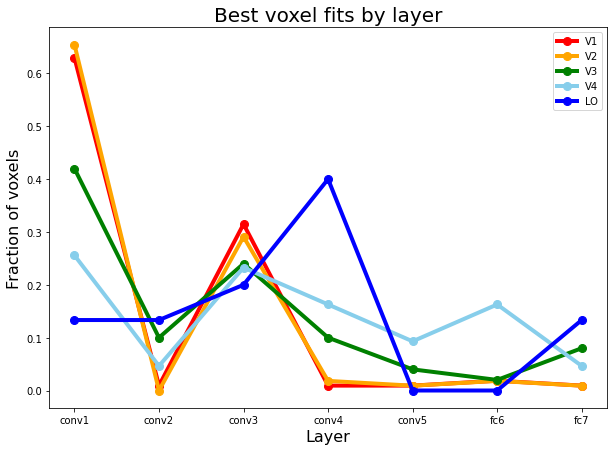

In [19]:
plt.figure(figsize=(10,7))
plt.plot(layer_keys, V1_props, marker='o', markerfacecolor='r', markersize=8, color='r', linewidth=4, label = 'V1')
plt.plot(layer_keys, V2_props, marker='o', markerfacecolor='orange', markersize=8, color='orange', linewidth=4, label = 'V2')
plt.plot(layer_keys, V3_props, marker='o', markerfacecolor='green', markersize=8, color='green', linewidth=4, label = 'V3')
plt.plot(layer_keys, V4_props, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, label = 'V4')
plt.plot(layer_keys, LO_props, marker='o', markerfacecolor='blue', markersize=8, color='blue', linewidth=4, label = 'LO')

plt.xlabel('Layer', fontsize = 16)
plt.ylabel('Fraction of voxels', fontsize = 16)
plt.title('Best voxel fits by layer', fontsize = 20)

plt.legend(loc='upper right')

plt.savefig('../figures/S1_layerwise_alexnet_untrained_fits.png') #phew!!!